/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,146,150,160,172,180,194,198,208,211,217,218,219,223,238,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,385,394) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Gender,Mean Salary median
Female,15000
Male,25000


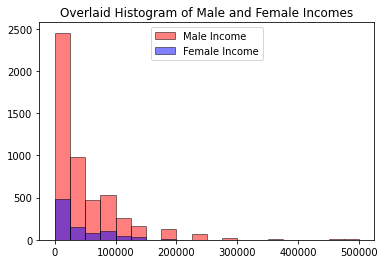

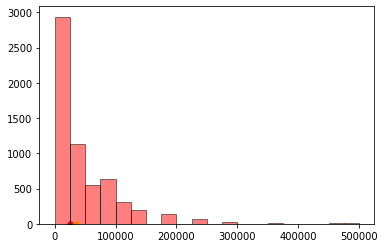

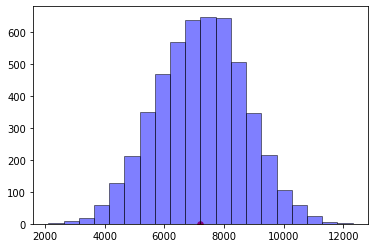

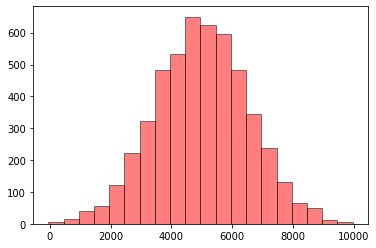

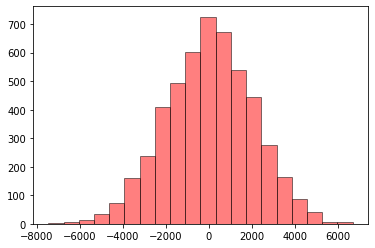

1.0002000400080016

In [18]:

#Importing the libraries which i would be using in the code

import datatable as dt
import datascience as ds
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
 
# to read the input file from the destination
input = pd.read_csv("/content/sample_data/multipleChoiceResponses.csv")
input = input.reindex(input.index.drop(0)).reset_index(drop=True)
input = input.dropna(how='any', subset=['Q9'])

#the following code is to find the means values
mean = {'0-10,000': 5000, '10-20,000': 15000, '20-30,000': 25000, '30-40,000': 35000,
       '40-50,000': 45000, '50-60,000': 55000, '60-70,000': 65000, '70-80,000': 75000,
       '80-90,000': 85000, '90-100,000': 95000, '100-125,000': 112500,
       '125-150,000': 137500, '150-200,000': 175000, '200-250,000': 225000,
       '250-300,000': 275000, '300-400,000': 350000, '400-500,000': 450000,
       '500,000+':500000,'I do not wish to disclose my approximate yearly compensation': 0}
input['Mean Salary'] = input['Q9'].apply(lambda value: mean[value])
  
#TO convert data in table format
table_input = ds.Table.from_df(input)
table_income = table_input.select(['Q1', 'Mean Salary'])
table_income = table_income.relabeled('Q1', 'Gender')
male_and_female = table_income.where('Gender', ds.are.containing('ale'))
male_and_female_medians = male_and_female.group('Gender', np.median)
# To find the medians based on gender
male_and_female_medians.show()



#2 code to plot overlaid histogram for income of female and male employees



male_female_income_df = male_and_female.to_df()
plt.hist(male_female_income_df[male_female_income_df['Gender']=='Male']['Mean Salary'], bins=20, alpha=0.5, label='Male Income', color="red")
plt.hist(male_female_income_df[male_female_income_df['Gender']=='Female']['Mean Salary'], bins=20, alpha=0.5, label='Female Income', color="blue")
plt.legend(loc='upper center')
plt.title('Overlaid Histogram of Male and Female Incomes')
plt.show()


# 3.1.Selecting the sample with 500 employees

male_income = male_and_female.where('Gender', ds.are.equal_to('Male'))
female_income = male_and_female.where('Gender', ds.are.equal_to('Female'))
male_sample = male_income.sample(250)
female_sample = female_income.sample(250)
male_sample_df = male_sample.to_df()
female_sample_df = female_sample.to_df()
sample = female_sample_df.append(male_sample_df, ignore_index=True)
sample_table = ds.Table.from_df(sample)

 

#3.3Code for drawing the sample for income histogram and then to plot median of male and female population
#Code to Draw the income histogram for the male and female income population 
plt.hist(male_female_income_df['Mean Salary'], bins = 20, alpha=0.5, label='Income', color="red")
plt.scatter(25000, 0, color='red', s=30)

plt.scatter(35000, 0, color='yellow', s=30)
plt.show()



#3.4. Drawing the histogram of test statistics of sample and plotting the observed statistcs on the graph using Testing Hypothesis
result = ds.make_array()
for c in np.arange(5000):
    male_sample = male_income.sample(2500)
    female_sample = female_income.sample(2500)
    male_sample_df = male_sample.to_df()
    female_sample_df = female_sample.to_df()
    sample = female_sample_df.append(male_sample_df, ignore_index=True)
    sample_table = ds.Table.from_df(sample)
    male_and_female_means = sample_table.group('Gender', np.average)
    male_and_female_means_df = male_and_female_means.to_df()
    result = np.append(result, male_and_female_means_df.iloc[1]['Mean Salary average'] - male_and_female_means_df.iloc[0]['Mean Salary average'])
mean_population = male_and_female.group('Gender', np.average).to_df()
observed_statistic = mean_population.iloc[1]['Mean Salary average'] - mean_population.iloc[0]['Mean Salary average']
 
plt.hist(result, bins = 20, alpha=0.5, label='Income', color="blue")
plt.scatter(observed_statistic, 0, color='red', s=30)
plt.show()


# 3.6.Code to draw income using bootstrap

bootstrap_result = ds.make_array()
for s in np.arange(5000):
    bootstrap_sample = sample_table.sample()
    bootstrap_male_and_female_means = bootstrap_sample.group('Gender', np.average)
    bootstrap_male_and_female_means_df = bootstrap_male_and_female_means.to_df()
    bootstrap_result = np.append(bootstrap_result, (bootstrap_male_and_female_means_df.iloc[1]['Mean Salary average'] - bootstrap_male_and_female_means_df.iloc[0]['Mean Salary average']))
plt.hist(bootstrap_result, bins = 20, alpha=0.5, label='Income', color="red")
plt.show()


#3.7. Finding p-value using the A/B Testing

shuffled_results = ds.make_array()
for s in np.arange(5000):
    shuffled_Genders = male_and_female.sample(with_replacement = False).column(0)
    original_and_shuffled = male_and_female.with_column('Shuffled Gender', shuffled_Genders)
    shuffled_only = original_and_shuffled.drop('Gender')
    shuffled_group_means = shuffled_only.group('Shuffled Gender', np.average)
    shuffled_group_means_df = shuffled_group_means.to_df()
    shuffled_results = np.append(shuffled_results, (shuffled_group_means_df.iloc[1]['Mean Salary average'] - shuffled_group_means_df.iloc[0]['Mean Salary average']))
plt.hist(shuffled_results, bins = 20, alpha=0.5, label='Income', color="red")
plt.show()
p_value = np.count_nonzero(shuffled_results <= observed_statistic) / s
p_value





In [7]:
pip install datatable

     |████████████████████████████████| 96.9 MB 93 kB/s 


In [3]:
#Installing all the python libraries required and used for this assignment module.
!pip install matplotlib